## Binary Classification Modeling - r/biology & r/biochemistry Predicting with Naive Bayes

In [19]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import recall_score, f1_score, precision_score, plot_confusion_matrix

#lemmatizer
import nltk
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
# Import stemmer.
from nltk.stem.porter import PorterStemmer
# Import RegEx Tokenizer
from nltk.tokenize import RegexpTokenizer, word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#get rid of userwarning when running code and getting tokenized words not in the stop words list
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
#read in the submissions csv file
#get rid of unnamed:0 column wtih index_col
submissions = pd.read_csv('datasets/cleaned-submission.csv',index_col=0)

In [4]:
#getting the information from submissions
#there are null values present
submissions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11007 entries, 0 to 6228
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  11007 non-null  object
 1   selftext   10941 non-null  object
 2   title      11002 non-null  object
dtypes: object(3)
memory usage: 344.0+ KB


In [5]:
#observing the presence of subreddit names within the text below
submissions.tail(2)

,subreddit,selftext,title
6227,Biochemistry,so far ive mostly looked for stuff in my homet...,wanting to take a year off between undergrad a...
6228,Biochemistry,im currently taking a biochemistry class at un...,biochemistry help


In [6]:
#drop any null values
submissions.dropna(axis=0,how='any',inplace=True)

In [7]:
#remove all words that apply to the target variable -- biology,bio,biochem,biochemistry
submissions['selftext'].replace('biology','',regex=True,inplace=True)
submissions['selftext'].replace('biochemistry','',regex=True,inplace=True)
submissions['selftext'].replace('chemistry','',regex=True,inplace=True)
submissions['selftext'].replace('biochem','',regex=True,inplace=True)
submissions['selftext'].replace('bio','',regex=True,inplace=True)
submissions['selftext'].replace('chem','',regex=True,inplace=True)

submissions['title'].replace('biology','',regex=True,inplace=True)
submissions['title'].replace('biochemistry','',regex=True,inplace=True)
submissions['title'].replace('chemistry','',regex=True,inplace=True)
submissions['title'].replace('biochem','',regex=True,inplace=True)
submissions['title'].replace('bio','',regex=True,inplace=True)
submissions['title'].replace('chem','',regex=True,inplace=True)

In [8]:
#observing the loss of subreddit names
#it is now removed from the text
submissions.tail(2)

,subreddit,selftext,title
6227,Biochemistry,so far ive mostly looked for stuff in my homet...,wanting to take a year off between undergrad a...
6228,Biochemistry,im currently taking a class at university im ...,help


In [9]:
#getting the shape of the submissions dataframe
submissions.shape

(10936, 3)

### Removing The Above Words Explained:

Part of the data science question I am interested in is whether the subreddits, r/biology and r/biochemsitry, can be classified using scientific terminology; for example carbohydrate metabolism or gymnosperm. Carbohydrate metabolism is one of the main biochemical processes that produces energy for cells. A gymnosperm is a group of seed-producing plants and a biological term. Therfore, I did not want versions of the words 'biology', which was present in over 2,000 of the r/biology selftext posts, or 'biochemsitry', which was present in over 1,500 biochemistry selftext posts, to have a significant influence on classification of the posts. In this project, I wished to solely focus the NLP model classification to prominent scientific terms or other meaningful words to classify the subreddits.

### Modeling with Title Text

In [10]:
#setting up initial X and y values -- using titles only first
#1 corresponds to biochemistry, 0 corresponds to biology
#need to make the str unicode with astype, emoji characters in the strings
#help with the unicode error found below:
#https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document
X = submissions['title'].values.astype('U')
y = np.where(submissions['subreddit']=='Biochemistry',1,0)

## Analysis of Most Common Title Text without Filtering

In [11]:
#count vectorize words to find the most common
cvect = CountVectorizer()
Xvect = cvect.fit_transform(X)
#make it a dataframe
dtm = pd.DataFrame(Xvect.toarray(),columns = cvect.get_feature_names())

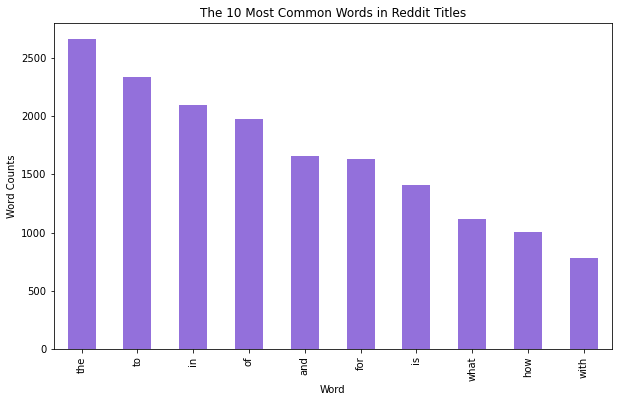

In [12]:
#make a graph of the most common words
dtm.sum().sort_values(ascending=False).head(10).plot(kind='bar',figsize=(10,6),
                                                    color='#9370DB')
plt.xlabel('Word')
plt.ylabel('Word Counts')
plt.title('The 10 Most Common Words in Reddit Titles');

#### Visualization Interpretation:

The graph above shows the 10 most common words in the titles of the subreddits posts from r/biology and r/biochemistry. As you can see, a majority of the most common words are prepositions - words such as the, to, in, etc. These prepositional words do not have any significant meaning to predicting whether a post will more likely be in r/biology or r/biochemistry so they will be removed from the models with the stop_words parameter in either CountVetorizer or TfidfVectorizer.

## Functions and Classes

In [13]:
#step over collection of tokens and try to lemmatize each of them
#to use in countvectorizer we pass the new class as the tokenizer
class LemmaTokenizer:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self,doc):
        return [self.lemmatizer.lemmatize(t) for t in word_tokenize(doc)]

In [14]:
#step over collection of word tokens and stemmatize
#create a class to pass into Countvectorizer in a pipeline
class StemTokenizer:
    def __init__(self):
        self.stemmatizer = PorterStemmer()
    def __call__(self,doc):
        return [self.stemmatizer.stem(t) for t in word_tokenize(doc)]

#### LemmaTokenizer and StemTokenizer Explained:

The two above classes, LemmaTokenize and StemTokenizer were created so that lemmatization or stemmatization of the text could be done within a CountVectorizer or TfidfVectorizer object. These classes are especially useful for doing lemmatizing or stemming within pipelines.

## Stopwords

In [15]:
#longer list of stop words
#taken from the open source work found here: https://gist.github.com/sebleier/554280
#txt found here: https://gist.githubusercontent.com/ZohebAbai/513218c3468130eacff6481f424e4e64/raw/b70776f341a148293ff277afa0d0302c8c38f7e2/gist_stopwords.txt

stop_word = pd.read_csv('datasets/stopwords.csv',index_col=0)
stop_word = list(stop_word['stopwords'])

#remove punctuation from the stop words, as it has already been done in cleaning the text
stop_word = [word.replace("'",'') for word in stop_word]

In [16]:
#updated stop_words to csv file for use in other modeling notebookes
#code cell can be used to append other stop_words to the csv file
#to make this occur uncomment the below code

# df_stopwords = pd.DataFrame({'stopwords':stop_word})
# df_stopwords.to_csv('./datasets/stopwords.csv')

#### stopwords.csv Explained:

I discovered through some investigation that the above stop words list allowed modeling to perform better, than usage of stop_words = 'english' in CountVectorizer and TfidfVectorizer. The removal of more extraneous words - which have no significance to r/biology or r/biochemistry - allowed for better accuracy in modeling that occurred below. Thus, I used a currated file of stop words in each other modeling notebook.

## Modeling With Only Title Text 

In [17]:
#stratify to get more equal target variables in the train/test split
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,random_state=18)

### Baseline Model With Text Only

In [18]:
#to get the baseline accuracy of the model
#based on the most frequent value in the training data
#biochemistry = 1, biology = 0

biochem_num = y_train.sum()
biology_num = len(y_train)-biochem_num

if biology_num < biochem_num:
    baseline_accur = round(biochem_num/len(y_train),4)
    print(f'The most frequent class is r/biochemistry. The accuracy of the null model is {baseline_accur}.')
    
else:
    baseline_accuracy = round((biology_num)/len(y_train),4)
    print(f'The most frequent class is r/biology. The accuracy of the null model is {baseline_accuracy}.')

The most frequent class is r/biochemistry. The accuracy of the null model is 0.5686.


#### Baseline/Null Model Explained:

The baseline model allows us to find a 'starting point' to compare the performance of future models to. In binary classification, a customary baseline/null model is one that will guess the most frequently occuring class in the training set. The code above is a way to print out what the baseline accuracy of the null model actually is. With the random state of the train/test split set, this accuracy should not change with future restarts of the kernel. The most frequent class is that of r/biochemistry. Therefore, there is a 56.8% accuracy if you were to guess r/biochemsitry for every observation within the data set. 

Let's see if we can't improve on this score with some NLP modeling!

## Scoring Metrics for this NLP Data Science Problem

The evaluation metric I want to focus on for this data science problem is both accuracy and recall. I want to try and optimize recall, along with accuracy - I think that this is important for several reasons. 


For accuracy, I want the NLP model to be able to predict the correct subreddit for a post as well as possible. In the cruel land of forums - depending on the subreddit or specific forum page - a user can become banned from that forum just for posting something that is not aligned with that page's identity. Also, if you are asking a specific biology/biochemistry question, you want your post to go to the right forum, so you can get the best answer/explanation possible.

For recall, I think, in this case, it is important to optimize the true positive rate. As we are trying to model towards a success of r/biochemistry, it is important to minimize the number of false negatives (incorrectly classified true r/biochemistry posts). r/biochemistry is a more specialized branch of biology and so it is important that you try to capture these biochemical/molecular-based posts into r/biochemistry, where they truly belong. Get as many r/biochemistry posts into the correct classification of r/biochemistry so you are getting the help you need from the members of that subreddit.

### Model One. Default Naive Bayes, CountVectorizer

In [106]:
#make a pipeline for Naive Bayes Classifer
#search pipeline through gridsearch
cvect_NB = CountVectorizer(stop_words = stop_word)
pipe_NB = make_pipeline(cvect_NB, StandardScaler(with_mean=False), MultinomialNB())

In [28]:
#initial model with minimal hyperparam tuning
#lemmatizer produce the following things not in stop words = 'ha','le','u','wa'
pipe_NB.fit(X_train,y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words=['0o', '0s', '3a', '3b', '3d', '6b',
                                             '6o', 'a', 'a1', 'a2', 'a3', 'a4',
                                             'ab', 'able', 'about', 'above',
                                             'abst', 'ac', 'accordance',
                                             'according', 'accordingly',
                                             'across', 'act', 'actually', 'ad',
                                             'added', 'adj', 'ae', 'af',
                                             'affected', ...])),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('multinomialnb', MultinomialNB())])

In [29]:
#the score on the training set is high, suspiciously high
pipe_NB.score(X_train,y_train)

0.894762484774665

In [30]:
#the score on the training set shows there is a lot of overfitting occuring 
#remove high variance with hyperparameter tuning
pipe_NB.score(X_test,y_test)

0.6784800876872488

In [31]:
#recall score on the first default naive bayes with title
recall_score(y_test,pipe_NB.predict(X_test))

0.7633440514469454

#### Model Interpretation:

This model is a sort of baseline model, to see if the hypertuning of parameters for both CountVectorization and the estimator, MultinomialNB, can improve the score. This 'default' model is already performing better than the baseline model. It is scoring approximately 10% better on accuracy than the null model and has a recall score of 76.3%. Let's see how hypertuning the parameters for this model changes the classification metrics we are interested in. We can also see that this default model is overfit to the training data, as there is a big difference between the accuracy scores for the training data and the holdout testing data.

### Model Two. GridSearchCV Naive Bayes

In [32]:
#params for bayes classifier
#Bayes with CountVectorizer
param_grid_NB = {
    'countvectorizer__max_features':[3_250,3_500,3_250],
    'multinomialnb__alpha':[3_975,3_965,3_980],
    'countvectorizer__ngram_range':[(1,1),(1,2),(2,2)]
}
grid_NB = GridSearchCV(pipe_NB,param_grid = param_grid_NB,n_jobs=-1)

In [33]:
#fit on the training data
grid_NB.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(stop_words=['0o', '0s',
                                                                    '3a', '3b',
                                                                    '3d', '6b',
                                                                    '6o', 'a',
                                                                    'a1', 'a2',
                                                                    'a3', 'a4',
                                                                    'ab',
                                                                    'able',
                                                                    'about',
                                                                    'above',
                                                                    'abst',
                                                                    'ac',
        

In [190]:
#get the best parameters
grid_NB.best_params_

{'countvectorizer__max_features': 3250,
 'countvectorizer__ngram_range': (1, 1),
 'multinomialnb__alpha': 3975}

In [35]:
#best accuracy score for the model
grid_NB.best_score_

0.7075517661388551

In [36]:
#score on the training data
grid_NB.score(X_train,y_train)

0.8029232643118148

In [37]:
#get a dataframe of the results
pd.DataFrame(grid_NB.cv_results_).sort_values(by='rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_countvectorizer__max_features,param_countvectorizer__ngram_range,param_multinomialnb__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.110300,0.006311,0.024022,0.005064,3250,"(1, 1)",3975,"{'countvectorizer__max_features': 3250, 'count...",0.705238,0.694884,0.70341,0.711937,0.72229,0.707552,0.009159,1
1,0.106897,0.006374,0.020619,0.001021,3250,"(1, 1)",3965,"{'countvectorizer__max_features': 3250, 'count...",0.705238,0.694884,0.70341,0.711937,0.72229,0.707552,0.009159,1
2,0.104896,0.003253,0.020418,0.000801,3250,"(1, 1)",3980,"{'countvectorizer__max_features': 3250, 'count...",0.705238,0.694884,0.70341,0.711937,0.72229,0.707552,0.009159,1


In [38]:
#score on different classification metrics
print(f'The accuracy of the Naive Bayes model is {round(grid_NB.score(X_test,y_test),4)}.')
print(f'The recall of the Naive Bayes model is {round(recall_score(y_test,grid_NB.predict(X_test)),4)}.')
print(f'The f1 score of the Naive Bayes model is {round(f1_score(y_test,grid_NB.predict(X_test)),4)}.')
print(f'The precision score of the Naive Bayes model is {round(precision_score(y_test,grid_NB.predict(X_test)),4)}.')

The accuracy of the Naive Bayes model is 0.696.
The recall of the Naive Bayes model is 0.8444.
The f1 score of the Naive Bayes model is 0.7594.
The precision score of the Naive Bayes model is 0.69.


#### Model Interpretation:

Model Two is Model One with hypertuning of the major parameters in the CountVectorizer transformer and MultinomialNB estimator. Compared to the 'default' Model One, this hypertuned model scores slightly better: ~2% better accuracy and ~10% better recall score. Model Two is way less overfit than Model One, creating a model with more accurate coefficient values.

### Model Three. GridSearchCV Naive Bayes, TfidfVectorizer

In [39]:
#instantiate tfidf vectorizer and pipeline
tfidf_nb = TfidfVectorizer()
pipenb_tfidf = make_pipeline(tfidf_nb, StandardScaler(with_mean=False),MultinomialNB())

In [43]:
#create parameters for the tfidf model
params = {
    'tfidfvectorizer__max_features':[5_000,6_500],
    'multinomialnb__alpha':[4_600,4_750,4_800],
    'tfidfvectorizer__ngram_range':[(1,1),(1,2),(2,2)]
}

In [44]:
#instantiate gridsearch object for tfidf
grid_tf = GridSearchCV(pipenb_tfidf,param_grid = params)

In [45]:
#fit training data to the tfidf gridsearch object
grid_tf.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('multinomialnb', MultinomialNB())]),
             param_grid={'multinomialnb__alpha': [4600, 4750, 4800],
                         'tfidfvectorizer__max_features': [5000, 6500],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (2, 2)]})

In [191]:
#accuracy on training set
#overfit model -- 7% higher training accuracy, than test accuracy
grid_tf.score(X_test,y_test)

0.770939548434086

In [46]:
#score on different classification metrics on title data
print(f'The accuracy of the Naive Bayes model with TfidfVectorization is {round(grid_tf.score(X_test,y_test),4)}.')
print(f'The recall of the Naive Bayes model with TfidfVectorization is {round(recall_score(y_test,grid_tf.predict(X_test)),4)}.')
print(f'The f1 score of the Naive Bayes model with TfidfVectorization is {round(f1_score(y_test,grid_tf.predict(X_test)),4)}.')
print(f'The precision score of the Naive Bayes with TfidfVectorization model is {round(precision_score(y_test,grid_tf.predict(X_test)),4)}.')

The accuracy of the Naive Bayes model with TfidfVectorization is 0.7015.
The recall of the Naive Bayes model with TfidfVectorization is 0.8418.
The f1 score of the Naive Bayes model with TfidfVectorization is 0.7622.
The precision score of the Naive Bayes with TfidfVectorization model is 0.6963.


In [47]:
#the best parameters for the gridsearch
grid_tf.best_params_

{'multinomialnb__alpha': 4600,
 'tfidfvectorizer__max_features': 5000,
 'tfidfvectorizer__ngram_range': (1, 1)}

In [48]:
#best estimator of the grid
grid_tf.best_estimator_

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_features=5000)),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('multinomialnb', MultinomialNB(alpha=4600))])

In [49]:
#get the top 2 results of the gridsearch parameters
pd.DataFrame(grid_tf.cv_results_).sort_values(by='rank_test_score').head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_multinomialnb__alpha,param_tfidfvectorizer__max_features,param_tfidfvectorizer__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.067862,0.001328,0.014613,0.00049,4600,5000,"(1, 1)","{'multinomialnb__alpha': 4600, 'tfidfvectorize...",0.694275,0.701583,0.709501,0.700974,0.718027,0.704872,0.008158,1
6,0.066661,0.000490,0.013812,0.00040,4750,5000,"(1, 1)","{'multinomialnb__alpha': 4750, 'tfidfvectorize...",0.693666,0.700365,0.710110,0.700974,0.716809,0.704385,0.008122,2


#### Model Interpretation:

Model Three is a Multinomial Naive Bayes performed with TfidfVectorization, rather than CountVectorization. TfidfVectorization measures the importance of a word based on how many times a word appears in a document versus the number of documents that word appears in. The TfidfVectorization slightly increases accuracy, but drops recall slightly. Overall there is not a significant difference between TfidfVectorization or CountVectorization - in terms of the evaluation metrics we are focusing on.

In [192]:
#grab the most important words for modeling with title
coefs = grid_NB.best_estimator_.named_steps['multinomialnb'].coef_
words = grid_NB.best_estimator_.named_steps['countvectorizer'].get_feature_names()
coefs_df = pd.DataFrame({'coefs':coefs[0]}, 
                       index = words)
coefs_df.nlargest(10,'coefs')

,coefs
protein,-7.837321
question,-7.848632
advice,-7.918840
enzyme,-7.928840
acid,-7.931591
amino,-7.941631
major,-7.947803
lab,-7.948100
proteins,-7.949230
phd,-7.954429


In [193]:
#the least important words for classification
coefs_df.nsmallest(10,'coefs')

,coefs
01mm,-8.116511
151,-8.116511
170,-8.116511
18449,-8.116511
2009,-8.116511
2019,-8.116511
2021,-8.116511
227,-8.116511
23,-8.116511
25c,-8.116511


## Modeling With Selftext Only

In this first notebook, I wanted to compare how using title text only, selftext only, and a combination of title and selftext would impact model scores. 

In [52]:
#total number of rows of selftext
len(submissions['selftext'])

10947

In [53]:
#setting up initial X and y values -- using titles only first
#1 corresponds to biochemistry, 0 corresponds to biology
#need to make the str unicode with astype, emoji characters in the strings
#help with the unicode error found below:
#https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document
X_selftext = submissions['selftext']
y = np.where(submissions['subreddit']=='Biochemistry',1,0)

In [54]:
#count vectorize words to find the most common
cvect_selftext = CountVectorizer()
Xvect_selftext = cvect_selftext.fit_transform(X_selftext)
#make it a dataframe
dtm_selftext = pd.DataFrame(Xvect_selftext.toarray(),columns = cvect_selftext.get_feature_names())

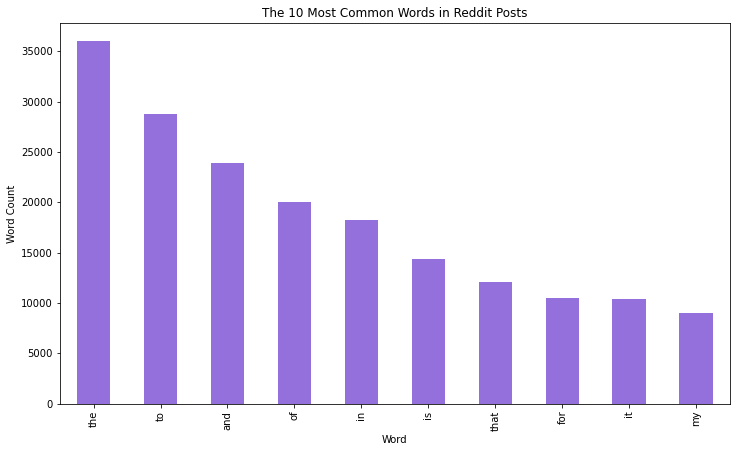

In [212]:
#make a graph of the most common words
dtm_selftext.sum().sort_values(ascending=False).head(10).plot(kind='bar',
                                                              figsize=(12,7),
                                                             color='#9370DB')
plt.xlabel('Word'),
plt.ylabel('Word Count')
plt.title('The 10 Most Common Words in Reddit Posts');

#### Visualization Interpretation:

The graph above shows the 10 most common words in the selftext/body of the subreddits posts from r/biology and r/biochemistry. As you can see, a majority of the most common words are prepositions - words such as the, to, in, etc. These prepositional words do not have any significant meaning to predicting whether a post will more likely be in r/biology or r/biochemistry so they will be removed from the models with the stop_words parameter in either CountVetorizer or TfidfVectorizer.

In [56]:
#another view of the top 10 most common words from the selftext
dtm_selftext.sum().sort_values(ascending=False).head(10)

the     36000
to      28784
and     23849
of      20028
in      18209
is      14331
that    12113
for     10490
it      10338
my       9003
dtype: int64

#### train/test split

In [57]:
#stratify to get more equal target variables in the train/test split
X_train,X_test,y_train,y_test = train_test_split(X_selftext,y,stratify=y)

### Baseline Model Score for Selftext Only Models

In [80]:
#to get the baseline accuracy of the model
#based on the most frequent value in the training data
#biochemistry = 1, biology = 0

biochem_num = y_train.sum()
biology_num = len(y_train)-biochem_num

if biology_num < biochem_num:
    baseline_accur = round(biochem_num/len(y_train),4)
    print(f'The most frequent class is r/biochemistry. The accuracy of the null model is {baseline_accur}.')
    
else:
    baseline_accuracy = round((biology_num)/len(y_train),4)
    print(f'The most frequent class is r/biology. The accuracy of the null model is {baseline_accuracy}.')

The most frequent class is r/biochemistry. The accuracy of the null model is 0.5686.


#### Baseline/Null Model Explained:

The baseline model allows us to find a 'starting point' to compare the performance of future models to. In binary classification, a customary baseline/null model is one that will guess the most frequently occuring class in the testing set. Baseline accuracy is 56.81%.

### Model One. Naive Bayes - CountVectorizer

In [59]:
#create pipeline for Naive Bayes modeling with selftext
cvect_selftext = CountVectorizer(stop_words=stop_word)
pipeNB_selftext = make_pipeline(cvect_selftext, StandardScaler(with_mean=False), MultinomialNB())
pipeNB_selftext.fit(X_train,y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words=['0o', '0s', '3a', '3b', '3d', '6b',
                                             '6o', 'a', 'a1', 'a2', 'a3', 'a4',
                                             'ab', 'able', 'about', 'above',
                                             'abst', 'ac', 'accordance',
                                             'according', 'accordingly',
                                             'across', 'act', 'actually', 'ad',
                                             'added', 'adj', 'ae', 'af',
                                             'affected', ...])),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('multinomialnb', MultinomialNB())])

In [60]:
#score
pipeNB_selftext.score(X_train,y_train)

0.9476248477466505

In [61]:
#the highest accuracy
pipeNB_selftext.score(X_test,y_test)

0.6814029959810011

In [62]:
#the recall score
recall_score(y_test,pipeNB_selftext.predict(X_test))

0.7427652733118971

#### Model Interpretation:

This is another 'default' model I used to gauge if hyperparameter tuning would increase the evaluation metrics of choice when using selftext to model. I also used this 'default' selftext model to compare the scores achieved with an exact model that used title text only as the predictive features. Comparing the two default models, there is not a large difference in accuracy and recall. The 'default' model is also highly overfit, and should be tuned to reduce this high variance, in hopes of improving the bias.

### Model Two. GridSearchCV Naive Bayes, CountVectorizer

In [63]:
#create the parameter grid for the gridsearchCV
param_selftext = {
    'countvectorizer__max_features': [1250,2500,3500],
    'countvectorizer__ngram_range':[(1,1),(1,2),(2,2)],
    'multinomialnb__alpha':[300,500,750]
}

In [64]:
#instantiate pipeline instance in GridSearchCV
grid_selftext = GridSearchCV(pipeNB_selftext, param_grid = param_selftext,n_jobs=-1)

#fit training data to gridsearch CV
grid_selftext.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(stop_words=['0o', '0s',
                                                                    '3a', '3b',
                                                                    '3d', '6b',
                                                                    '6o', 'a',
                                                                    'a1', 'a2',
                                                                    'a3', 'a4',
                                                                    'ab',
                                                                    'able',
                                                                    'about',
                                                                    'above',
                                                                    'abst',
                                                                    'ac',
        

In [65]:
#best score
grid_selftext.score(X_train,y_train)

0.7867235079171742

In [66]:
#score on different classification metrics
print(f'The accuracy of the Naive Bayes model with CountVectorization is {round(grid_selftext.score(X_test,y_test),4)}.')
print(f'The recall of the Naive Bayes model with CountVectorization is {round(recall_score(y_test,grid_selftext.predict(X_test)),4)}.')
print(f'The f1 score of the Naive Bayes model with CountVectorization is {round(f1_score(y_test,grid_selftext.predict(X_test)),4)}.')
print(f'The precision score of the Naive Bayes model with CountVectorization is {round(precision_score(y_test,grid_selftext.predict(X_test)),4)}.')

The accuracy of the Naive Bayes model with CountVectorization is 0.741.
The recall of the Naive Bayes model with CountVectorization is 0.8521.
The f1 score of the Naive Bayes model with CountVectorization is 0.7889.
The precision score of the Naive Bayes model with CountVectorization is 0.7345.


In [67]:
#best parameters
grid_selftext.best_params_

{'countvectorizer__max_features': 3500,
 'countvectorizer__ngram_range': (1, 1),
 'multinomialnb__alpha': 500}

In [68]:
pd.DataFrame(grid_selftext.cv_results_).sort_values(by='rank_test_score').head(4)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_countvectorizer__max_features,param_countvectorizer__ngram_range,param_multinomialnb__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
19,0.517604,0.028674,0.127115,0.025885,3500,"(1, 1)",500,"{'countvectorizer__max_features': 3500, 'count...",0.750305,0.739342,0.728380,0.744823,0.739951,0.740560,0.007257,1
18,0.521895,0.011370,0.110300,0.010694,3500,"(1, 1)",300,"{'countvectorizer__max_features': 3500, 'count...",0.746650,0.740560,0.727162,0.745432,0.740560,0.740073,0.006916,2
21,1.623076,0.006411,0.152138,0.011961,3500,"(1, 2)",300,"{'countvectorizer__max_features': 3500, 'count...",0.744214,0.739342,0.722899,0.744823,0.747868,0.739829,0.008896,3
22,1.614869,0.045272,0.170755,0.014035,3500,"(1, 2)",500,"{'countvectorizer__max_features': 3500, 'count...",0.747868,0.734470,0.722899,0.739951,0.747868,0.738611,0.009351,4


#### Model Interpretation:

Model Two was where I began to see that the selftext only was scoring better on accuracy, than with the title text. The accuracy of Model Two scored about ~3% better than any of the models which used title text. For the remainder of models which used selftext I kept a close on the accuracy score between title and selftext, you will see that the selftext models perform better on accuracy across the board.

### Model Three. GridSearchCV Naive Bayes with TfidfVectorizer

In [69]:
#instantiate tfidf vectorizer and pipeline
tfdfNB_selftext = TfidfVectorizer(stop_words = stop_word)
pipeNBtddf_selftext = make_pipeline(tfdfNB_selftext, StandardScaler(with_mean=False),MultinomialNB())

In [70]:
#parameter grid for TfidfVectorizer and Bayes
param_tfdf_selftext = {
    'tfidfvectorizer__max_features': [4_750,5_000,5_250],
    'tfidfvectorizer__ngram_range':[(1,1),(1,2)],
    'multinomialnb__alpha':[635,650,645,630]
}

In [71]:
#fit training data to tfidf gridsearch
grid_tfdf_self = GridSearchCV(pipeNBtddf_selftext,param_grid=param_tfdf_selftext,n_jobs=-1)
grid_tfdf_self.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words=['0o', '0s',
                                                                    '3a', '3b',
                                                                    '3d', '6b',
                                                                    '6o', 'a',
                                                                    'a1', 'a2',
                                                                    'a3', 'a4',
                                                                    'ab',
                                                                    'able',
                                                                    'about',
                                                                    'above',
                                                                    'abst',
                                                                    'ac',
        

In [72]:
#the accuracy score on the training set
grid_tfdf_self.score(X_train,y_train)

0.8237515225334957

In [73]:
#the best parameters
grid_tfdf_self.best_params_

{'multinomialnb__alpha': 650,
 'tfidfvectorizer__max_features': 5000,
 'tfidfvectorizer__ngram_range': (1, 2)}

In [74]:
#score on different classification metrics
print(f'The accuracy of the Naive Bayes model with TfidfVectorization is {round(grid_tfdf_self.score(X_test,y_test),4)}.')
print(f'The recall of the Naive Bayes model with TfidfVectorization is {round(recall_score(y_test,grid_tfdf_self.predict(X_test)),4)}.')
print(f'The f1 score of the Naive Bayes model with TfidfVectorization is {round(f1_score(y_test,grid_tfdf_self.predict(X_test)),4)}.')
print(f'The precision score of the Naive Bayes model with TfidfVectorization is {round(precision_score(y_test,grid_tfdf_self.predict(X_test)),4)}.')

The accuracy of the Naive Bayes model with TfidfVectorization is 0.7421.
The recall of the Naive Bayes model with TfidfVectorization is 0.8553.
The f1 score of the Naive Bayes model with TfidfVectorization is 0.7903.
The precision score of the Naive Bayes model with TfidfVectorization is 0.7344.


In [75]:
pd.DataFrame(grid_tfdf_self.cv_results_).sort_values(by='rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_multinomialnb__alpha,param_tfidfvectorizer__max_features,param_tfidfvectorizer__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,1.519801,0.029804,0.160946,0.006437,650,5000,"(1, 2)","{'multinomialnb__alpha': 650, 'tfidfvectorizer...",0.755177,0.750305,0.726553,0.747259,0.755786,0.747016,0.010706,1
20,0.524888,0.024791,0.102093,0.006393,630,5000,"(1, 1)","{'multinomialnb__alpha': 630, 'tfidfvectorizer...",0.761267,0.754568,0.720463,0.742996,0.755177,0.746894,0.014477,2
8,0.517871,0.028229,0.109900,0.007815,650,5000,"(1, 1)","{'multinomialnb__alpha': 650, 'tfidfvectorizer...",0.761876,0.754568,0.720463,0.742996,0.754568,0.746894,0.014533,2


#### Model Interpretation:

Model Three is the best scoring model for selftext, performing slightly better than the other models on both accuracy and recall, with approximately 74% and 86% respectively. As I am aiming to optimize these parameters, I knew that this was the model I wanted to try and improve using the AdaBoost algorithm. There is a overfitting present in this model, which I want to see if it could be reduced with AdaBoost.

### Model Four. TfidfVectorizer, LemmaTokenizer

In [79]:
#instantiate tfidf vectorizer and pipeline
tfdfNB_lemma = TfidfVectorizer(stop_words = stop_word,tokenizer = LemmaTokenizer())
pipelemma_selftext = make_pipeline(tfdfNB_lemma, StandardScaler(with_mean=False),MultinomialNB())

In [80]:
#instantiate gridsearchCV values
grid_tflemma = GridSearchCV(pipelemma_selftext,param_grid = param_tfdf_selftext)

#fit gridsearch to training data
grid_tflemma.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words=['0o', '0s',
                                                                    '3a', '3b',
                                                                    '3d', '6b',
                                                                    '6o', 'a',
                                                                    'a1', 'a2',
                                                                    'a3', 'a4',
                                                                    'ab',
                                                                    'able',
                                                                    'about',
                                                                    'above',
                                                                    'abst',
                                                                    'ac',
        

In [81]:
#best parameters for the gridsearch
grid_tflemma.best_params_

{'multinomialnb__alpha': 650,
 'tfidfvectorizer__max_features': 5250,
 'tfidfvectorizer__ngram_range': (1, 2)}

In [83]:
#cast the results of the grid to a dataframe
pd.DataFrame(grid_tflemma.cv_results_).sort_values(by='rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_multinomialnb__alpha,param_tfidfvectorizer__max_features,param_tfidfvectorizer__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,3.981419,0.068977,0.868293,0.036444,650,5250,"(1, 2)","{'multinomialnb__alpha': 650, 'tfidfvectorizer...",0.758831,0.752741,0.736297,0.749086,0.755177,0.750426,0.007746,1
17,3.937206,0.029469,0.862052,0.035466,645,5250,"(1, 2)","{'multinomialnb__alpha': 645, 'tfidfvectorizer...",0.758222,0.752741,0.736297,0.749086,0.755177,0.750305,0.007616,2
5,3.892781,0.044819,0.858433,0.035940,635,5250,"(1, 2)","{'multinomialnb__alpha': 635, 'tfidfvectorizer...",0.758222,0.753350,0.735079,0.749086,0.755177,0.750183,0.008111,3


In [84]:
#score on the test data
grid_tflemma.score(X_test,y_test)

0.7398611618560468

In [85]:
#score on the training set
grid_tflemma.score(X_train,y_train)

0.8258221680876979

In [86]:
#score on different classification metrics
print(f'The accuracy of the Naive Bayes model with TfidfVectorization & Lemmatization is {round(grid_tflemma.score(X_test,y_test),4)}.')
print(f'The recall of the Naive Bayes model with TfidfVectorization & Lemmatization is {round(recall_score(y_test,grid_tflemma.predict(X_test)),4)}.')
print(f'The f1 score of the Naive Bayes model with TfidfVectorization & Lemmatization is {round(f1_score(y_test,grid_tflemma.predict(X_test)),4)}.')
print(f'The precision score of the Naive Bayes model with TfidfVectorization & Lemmatization is {round(precision_score(y_test,grid_tflemma.predict(X_test)),4)}.')

The accuracy of the Naive Bayes model with TfidfVectorization & Lemmatization is 0.7399.
The recall of the Naive Bayes model with TfidfVectorization & Lemmatization is 0.8617.
The f1 score of the Naive Bayes model with TfidfVectorization & Lemmatization is 0.7901.
The precision score of the Naive Bayes model with TfidfVectorization & Lemmatization is 0.7295.


#### Model Interpretation.

The TfidfVectorization with Lemmatization Model scores the same as the TfidfVectorization Model without Lemmatization, though the Lemmatized Model 4 contains no overfitting. Therefore we have more confidence in the coefficients and stability of Model Four, than compared to Model 3.

In [91]:
#grabbing the most important words from tfidf with lemmatization
coefs_lemma = grid_tflemma.best_estimator_.named_steps['multinomialnb'].coef_
words_lemma = grid_tflemma.best_estimator_.named_steps['tfidfvectorizer'].get_feature_names()
coefs_lemma = pd.DataFrame({'coefs':coefs_lemma[0]}, 
                       index = words_lemma)
coefs_lemma.nlargest(11,'coefs')

,coefs
protein,-7.493425
year,-7.544414
ha,-7.587363
lab,-7.592660
doe,-7.600065
work,-7.646900
question,-7.663086
school,-7.677455
acid,-7.682536
time,-7.703733


### Interpretation

The small dataframe above shows the largest/most important words for predicting the binary classification of r/biochemistry or r/biology. We can see that there are several biochemistry specific words at the top of this list, such as protien, enzyme and acid.

In [92]:
#grabbing the words with the least impact on biochemistry classification
coefs_lemma.nsmallest(10,'coefs')

,coefs
2 frighteningly,-8.858938
2 retrained,-8.858938
463053892,-8.858938
5 foot,-8.858938
acting questionanswering,-8.858938
adblocker,-8.858938
adblocker pending,-8.858938
adventure game,-8.858938
ai chat,-8.858938
ai context,-8.858938


### Interpretation

The small dataframe above shows the smallest/least important words for predicting the binary classification problem. We can see that these words, in alphabetical order (with numbers before letters), consist of spam/ad type words, such as ai chat or adventure game which have a significant presence in the r/biology subreddit.

## Combined Text Columns Modeling with Naive Bayes

#### Pre-Modeling Cleaning

In [20]:
#read in the combined text csv
combined = pd.read_csv('datasets/combined_title_self.csv',index_col=0)

In [21]:
#shows that there are null values in the datafile
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22014 entries, 0 to 22013
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  22014 non-null  object
 1   text       21943 non-null  object
dtypes: object(2)
memory usage: 516.0+ KB


In [22]:
#drop the null values from the dataframe
combined.dropna(inplace=True)

In [23]:
#the number of observations for the combined dataframe
combined.shape

(21943, 2)

In [24]:
#remove all words that apply to the target variable -- biology,bio,biochem,biochemistry
combined['text'].replace('biology','',regex=True,inplace=True)
combined['text'].replace('biochemistry','',regex=True,inplace=True)
combined['text'].replace('chemistry','',regex=True,inplace=True)
combined['text'].replace('biochem','',regex=True,inplace=True)
combined['text'].replace('bio','',regex=True,inplace=True)
combined['text'].replace('chem','',regex=True,inplace=True)

### Set up for Modeling

In [25]:
#setting up initial X and y values
#1 corresponds to biochemistry, 0 corresponds to biology
#need to make the str unicode with astype, emoji characters in the strings
#help with the unicode error found below:
#https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document
X_combo = combined['text']
y = np.where(combined['subreddit']=='Biochemistry',1,0)

In [26]:
#train/test split of the data
X_train,X_test,y_train,y_test = train_test_split(X_combo,y,stratify=y,random_state=18)

### Most Common Words

In [27]:
#count vectorize words to find the most common
cvect_selftext = CountVectorizer()
Xcombo_selftext = cvect_selftext.fit_transform(X_combo)
#make it a dataframe
dtm_combo = pd.DataFrame(Xcombo_selftext.toarray(),columns = cvect_selftext.get_feature_names())

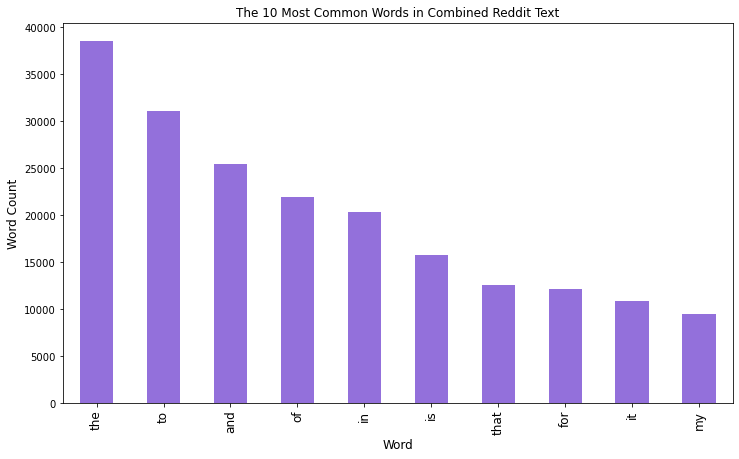

In [28]:
#make a graph of the most common words
dtm_combo.sum().sort_values(ascending=False).head(10).plot(kind='bar',
                                                              figsize=(12,7),
                                                             color='#9370DB')
plt.xlabel('Word',fontsize=12),
plt.ylabel('Word Count',fontsize=12)
plt.xticks(fontsize=12)
plt.title('The 10 Most Common Words in Combined Reddit Text',fontsize=12)
plt.savefig('images/most_common.png',bbox_inches='tight', dpi=600);

#### Visualization Interpretation:

The graph above shows the 10 most common words in the selftext/body of the subreddits posts from r/biology and r/biochemistry. As you can see, a majority of the most common words are prepositions - words such as the, to, in, etc. These prepositional words do not have any significant meaning to predicting whether a post will more likely be in r/biology or r/biochemistry so they will be removed from the models with the stop_words parameter in either CountVetorizer or TfidfVectorizer.

## Baseline Model for Combined Text Models

In [29]:
#to get the baseline accuracy of the model
#based on the most frequent value in the training data
#biochemistry = 1, biology = 0

biochem_num = y_train.sum()
biology_num = len(y_train)-biochem_num

if biology_num < biochem_num:
    baseline_accur = round(biochem_num/len(y_train),4)
    print(f'The most frequent class is r/biochemistry. The accuracy of the null model is {baseline_accur}.')
    
else:
    baseline_accuracy = round((biology_num)/len(y_train),4)
    print(f'The most frequent class is r/biology. The accuracy of the null model is {baseline_accuracy}.')

The most frequent class is r/biochemistry. The accuracy of the null model is 0.5673.


#### Baseline/Null Model Explained:

The baseline model allows us to find a 'starting point' to compare the performance of future models to. In binary classification, a customary baseline/null model is one that will guess the most frequently occuring class in the testing set.

### Model One. CountVectorizer, Naive Bayes

In [30]:
#create pipeline for Naive Bayes modeling with selftext
cvect_combo= CountVectorizer(stop_words=stop_word)
pipeNB_combo = make_pipeline(cvect_combo, StandardScaler(with_mean=False), MultinomialNB())

In [31]:
#create the parameter grid for the gridsearchCV
param_combo = {
    'countvectorizer__max_features': [5_500,6_000,5_250],
    'countvectorizer__ngram_range':[(1,1),(1,2)],
    'multinomialnb__alpha':[750,800,825,900]
}

In [32]:
#instantiate the gridsearch instance
grid_combo = GridSearchCV(pipeNB_combo,param_grid=param_combo,n_jobs=-1)

#fit the training data to the gridsearch
grid_combo.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(stop_words=['0o', '0s',
                                                                    '3a', '3b',
                                                                    '3d', '6b',
                                                                    '6o', 'a',
                                                                    'a1', 'a2',
                                                                    'a3', 'a4',
                                                                    'ab',
                                                                    'able',
                                                                    'about',
                                                                    'above',
                                                                    'abst',
                                                                    'ac',
        

In [33]:
#best parameters
grid_combo.best_params_

{'countvectorizer__max_features': 6000,
 'countvectorizer__ngram_range': (1, 1),
 'multinomialnb__alpha': 800}

In [34]:
#the predictions for grid_combo on the test/holdout data
print(f"The model's predictions on the first ten observations in the testing data {grid_combo.predict(X_test)[:10]}.")
print(f"The true values of the first ten observations in the testing data {y_test[:10]}.")
print('__________________________________________________________________________________')
print('')
print(f"The text that corresponds to the first ten observations in the testing data: \n {X_test[:10]}.")

The model's predictions on the first ten observations in the testing data [0 1 1 1 0 0 0 0 0 1].
The true values of the first ten observations in the testing data [1 1 1 1 0 1 0 0 1 1].
__________________________________________________________________________________

The text that corresponds to the first ten observations in the testing data: 
 16245    hi question about amoxicillin and gramnegative...
20641    quick basic question on net charge of peptides...
5353                                              help plz
20904               what path did you take after your  bsc
375      i was looking to find out how the speed of ele...
10711    are there any examples of combining crisprcas9...
15407                                    dissection videos
3435     suppose you have a time machine and the cycle ...
21477    obscure question why does saliva cause things ...
6127     i would like to make a quality presentation on...
Name: text, dtype: object.


#### Predictions Comparison

In the above true test values and predictions made by the model, we can see that the model can correctly predict differences in scientitic terminology. The two posts I want to draw attention to are:

'cargo transport in our cells dynein', which is correctly classified as an r/biochemistry post and 'what could happen if the cells could survive a day longer in the body' which is correctly classified as a r/biology post. Though both posts have to do with cells, the model is correctly able to classify the other terminology correctly and predict microscopic level differences between biology and biochemistry based on terminology.

In [35]:
#scoring on the training data
grid_combo.score(X_train,y_train)

0.7841647930971622

In [36]:
#score on different classification metrics
print(f'The accuracy of the Naive Bayes model with combined text is {round(grid_combo.score(X_test,y_test),4)}.')
print(f'The recall of the Naive Bayes model with combined text is {round(recall_score(y_test,grid_combo.predict(X_test)),4)}.')
print(f'The f1 score of the Naive Bayes model with combined text is {round(f1_score(y_test,grid_combo.predict(X_test)),4)}.')
print(f'The precision score of the Naive Bayes model with combined text is {round(precision_score(y_test,grid_combo.predict(X_test)),4)}.')

The accuracy of the Naive Bayes model with combined text is 0.7457.
The recall of the Naive Bayes model with combined text is 0.8541.
The f1 score of the Naive Bayes model with combined text is 0.7921.
The precision score of the Naive Bayes model with combined text is 0.7385.


In [37]:
#dataframe of grid results
pd.DataFrame(grid_combo.cv_results_).sort_values(by='rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_countvectorizer__max_features,param_countvectorizer__ngram_range,param_multinomialnb__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,0.591342,0.011519,0.123315,0.002790,6000,"(1, 1)",800,"{'countvectorizer__max_features': 6000, 'count...",0.734812,0.737849,0.750836,0.742024,0.729262,0.738956,0.007251,1
10,0.609566,0.029373,0.131325,0.004530,6000,"(1, 1)",825,"{'countvectorizer__max_features': 6000, 'count...",0.734204,0.737849,0.750836,0.742328,0.728654,0.738774,0.007514,2
8,0.587750,0.034669,0.131319,0.018644,6000,"(1, 1)",750,"{'countvectorizer__max_features': 6000, 'count...",0.735115,0.737849,0.750836,0.741720,0.728350,0.738774,0.007444,3


#### Model Interpretation

Model One of combined title and selftext similarly as Model Three of Selftext, the only significant difference is that Model One contains no overfitting - as the accuracy of the training score is very close to the accuracy of the testing data. This makes the Model One of combined text more stable in coefficient values and makes us more confident in it's performance as a predictor.

This model was chosen as the final model for several reasons: it has one of the highest pair-wise scores for accuracy and recall, and is not overfit. Many other models that scored similarly to this model contained overfitting/high variance. The lack of variance in this model makes me more confident that it is a more stable predictor.

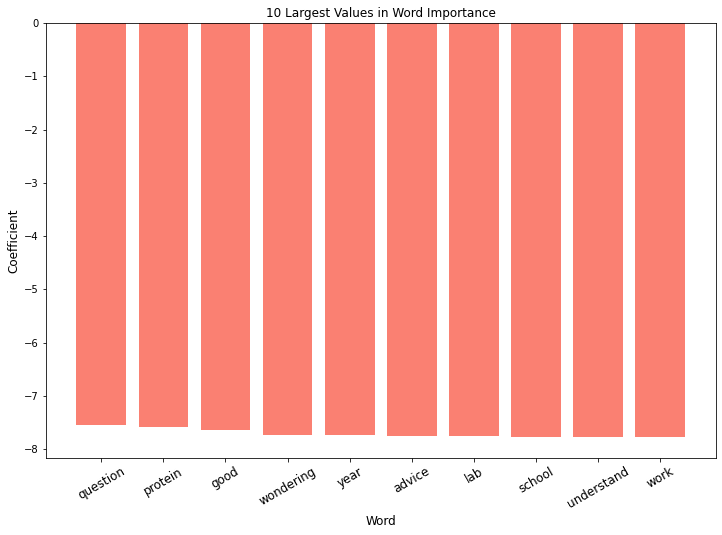

In [38]:
#create graph of the most important words for classifying something as biochemistry
coefs0 = grid_combo.best_estimator_.named_steps['multinomialnb'].coef_
words0 = grid_combo.best_estimator_.named_steps['countvectorizer'].get_feature_names()
coefs0 = pd.DataFrame({'coefs':coefs0[0]}, 
                       index = words0).nlargest(10,'coefs')
#manipulation and creation of the graph
plt.figure(figsize=(12,8))
plt.bar(x = coefs0.index,height = coefs0['coefs'],color='#FA8072')
plt.title('10 Largest Values in Word Importance',fontsize=12)
plt.xlabel('Word',fontsize=12)
plt.ylabel('Coefficient',fontsize=12)
plt.xticks(rotation=30,fontsize=12)
plt.savefig('images/largest_coefs.png',bbox_inches='tight', dpi=300);

#### Visualization Interpretation

The above visualization shows 10 most important words for classifying a post for r/biochemistry. These words had the highest coefficients, as they are negative the lowest negative number will be the largest, and where therefore deemed the most important features. Many of the posts in r/biochemistrywere not scientific questions as I thought, but were advice posts - asking about the best schools to get a biochemistry degree, etc. In this case, it makes sense that some of these words would appear within the most important words, such as the word question.

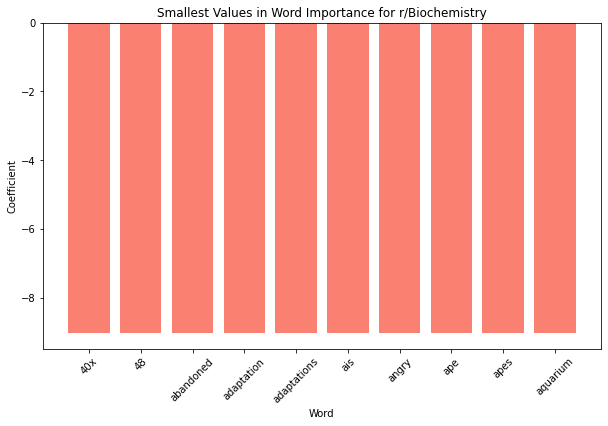

In [39]:
#create graph of the most important words for classifying something as biochemistry
coefs1 = grid_combo.best_estimator_.named_steps['multinomialnb'].coef_
words1 = grid_combo.best_estimator_.named_steps['countvectorizer'].get_feature_names()
coefs1 = pd.DataFrame({'coefs':coefs1[0]}, 
                       index = words1).nsmallest(10,'coefs')
#manipulation and creation of the graph
plt.figure(figsize=(10,6))
plt.bar(x = coefs1.index,height = coefs1['coefs'],color='#FA8072')
plt.title('Smallest Values in Word Importance for r/Biochemistry')
plt.xlabel('Word')
plt.ylabel('Coefficient')
plt.xticks(rotation=45)
plt.savefig('images/smallest_coefs.png',bbox_inches='tight', dpi=600);

#### Visualization Interpretation

The above visualization shows a sampling of the most important words in classfying a post as being from r/biology. These words show that there are several biology terms and some spam that was prevalent within the r/biology subreddit. 40x signifies the 40 times magnification of an objective of a microscope, which in turn results in 400x magnification (10x ocular).

These words are in alphebetical order and there are approximately 200 words which have this same coefficient value, but many aren't shown in the above visualization.Many biology terms made this list: gametes, fitness, phylogenetic tree, meiosis, oocytes, to name a few.

In [40]:
#grabbing the most important words from tfidf with lemmatization
coefs_comb = grid_combo.best_estimator_.named_steps['multinomialnb'].coef_
words_comb = grid_combo.best_estimator_.named_steps['countvectorizer'].get_feature_names()
coefs_comb = pd.DataFrame({'coefs':coefs_comb[0]}, 
                       index = words_comb)
coefs_comb.nsmallest(200,'coefs')

,coefs
40x,-9.034324
48,-9.034324
abandoned,-9.034324
adaptation,-9.034324
adaptations,-9.034324
...,...
wound,-9.034324
xylem,-9.034324
zoo,-9.034324
lockdown,-9.022726


### Interpretation

The above small dataframe show the smallest coefficient values of the final production model. Aproximately 200 words were the least important to classifying the r/biochemistry subreddit.

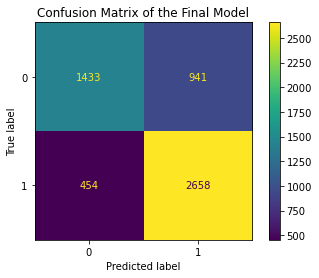

In [42]:
#confusion matrix of the values
plot_confusion_matrix(grid_combo,X_test,y_test)
plt.title('Confusion Matrix of the Final Model');

### Interpretation

Above is a confusion matrix of the final production model, Model One with CountVectorization and MultinomialNB estimator. In the visualization 1 corresponds to r/biochemistry and 0 corresponds to r/biology. The top left corner represents the false positive values, as you can see about 2/3 of the misclassifications the model made are actually false positives (r/biology posts being classified as r/biochemistry posts). This is important to note, as we are trying to optimize recall. This big error in false positive misclassification may be do to the more general nature of the r/biology posts, and have less differentiable words.

### Model Two. TfidfVectorization with Naive Bayes for Combined Text

In [109]:
#instantiate tfidf vectorizer and pipeline
tfdfNB_combo = TfidfVectorizer(stop_words = stop_word)
pipeNBtddf_combo = make_pipeline(tfdfNB_combo, StandardScaler(with_mean=False),MultinomialNB())

In [110]:
#parameter grid for TfidfVectorizer and Bayes with combined text
param_tfdf_combo = {
    'tfidfvectorizer__max_features': [5_000,6_000],
    'tfidfvectorizer__ngram_range':[(1,1),(1,2),(2,2)],
    'multinomialnb__alpha':[1,10,5]
}

In [111]:
#create gridsearch for combined text with tfidfvectorization
grid_combo_tfdf = GridSearchCV(pipeNBtddf_combo,param_grid = param_tfdf_combo,n_jobs=-1)

#fit the grid to the training data
grid_combo_tfdf.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words=['0o', '0s',
                                                                    '3a', '3b',
                                                                    '3d', '6b',
                                                                    '6o', 'a',
                                                                    'a1', 'a2',
                                                                    'a3', 'a4',
                                                                    'ab',
                                                                    'able',
                                                                    'about',
                                                                    'above',
                                                                    'abst',
                                                                    'ac',
        

In [112]:
#score accuracy on the training data
grid_combo_tfdf.score(X_train,y_train)

0.8042250956109999

In [113]:
#best parameters
grid_combo_tfdf.best_params_

{'multinomialnb__alpha': 10,
 'tfidfvectorizer__max_features': 5000,
 'tfidfvectorizer__ngram_range': (1, 2)}

In [114]:
#score on different classification metrics
print(f'The accuracy of the Naive Bayes model with combined text is {round(grid_combo_tfdf.score(X_test,y_test),4)}.')
print(f'The recall of the Naive Bayes model with combined text is {round(recall_score(y_test,grid_combo_tfdf.predict(X_test)),4)}.')
print(f'The f1 score of the Naive Bayes model with combined text is {round(f1_score(y_test,grid_combo_tfdf.predict(X_test)),4)}.')
print(f'The precision score of the Naive Bayes model with combined text is {round(precision_score(y_test,grid_combo_tfdf.predict(X_test)),4)}.')

The accuracy of the Naive Bayes model with combined text is 0.7294.
The recall of the Naive Bayes model with combined text is 0.7934.
The f1 score of the Naive Bayes model with combined text is 0.7687.
The precision score of the Naive Bayes model with combined text is 0.7455.


#### Model Interpretation:

The TfidfVectorization with the combined text performed several percentage points worse in the recall metric and had slightly more overfitting than Model One with combined text.

#### Conclusions:

Comparing all of the text values together - seltext, title, and the combined text - I discovered that selftext and combined title+selftext coincided with similar model scores in accuracy and recall. Although, the combined text column scored better with 75% accuracy and 86% recall, without overfitting. Combining the selftext and title data and ultimately producing more data for a model to train on reduces the variance of the models produced, leading to more stable models we can have higher confidence in.